In [1]:
import cv2 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from __future__ import division

import pycwt as wavelet
from pycwt.helpers import find
%matplotlib inline

In [2]:
pyplot=plt
numpy = np

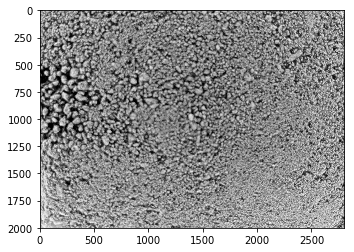

In [3]:
img_path = '../data/CroppedImages/'
imgs_names = os.listdir(img_path)
img_name = imgs_names[0]
img = cv2.imread(img_path+img_name,0)
plt.imshow(img,cmap='gray')

In [176]:
img[1 , :].size
dat = img[1 , :]
dt = .10
t0 = 0


In [130]:
dat.shape

(2800,)

In [131]:
N = dat.size
t = numpy.arange(0, N) * dt + t0

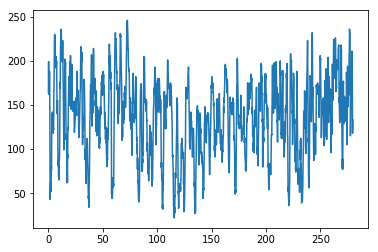

In [132]:
plt.plot(t,dat)

In [133]:
p = numpy.polyfit(t - t0, dat, 1)
dat_notrend = dat - numpy.polyval(p, t - t0)
std = dat_notrend.std() # Standard deviation
var = std ** 2 # Variance
dat_norm = dat_notrend / std # Normalized dataset

In [134]:
mother = wavelet.Morlet(6)
s0 = 2 * dt # Starting scale, in this case 2 * 0.25 years = 6 months
dj = 1 / 12 # Twelve sub-octaves per octaves
J = 7 / dj # Seven powers of two with dj sub-octaves
alpha, _, _ = wavelet.ar1(dat) # Lag-1 autocorrelation for red noise

In [135]:
wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J,
mother)
iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std

In [136]:
power = (numpy.abs(wave)) ** 2
fft_power = numpy.abs(fft) ** 2
period = 1 / freqs

In [137]:
power /= scales[:, None]

In [138]:
signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
significance_level=0.95,
wavelet=mother)
sig95 = numpy.ones([1, N]) * signif[:, None]
sig95 = power / sig95

In [139]:
glbl_power = power.mean(axis=1)
dof = N - scales # Correction for padding at edges

In [140]:
glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
significance_level=0.95, dof=dof,
wavelet=mother)


In [141]:
sel = find((period >= 2) & (period < 8))
Cdelta = mother.cdelta
scale_avg = (scales * numpy.ones((N, 1))).transpose()
scale_avg = power / scale_avg # As in Torrence and Compo (1998) equation 24
scale_avg = var * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
scale_avg_signif, tmp = wavelet.significance(var, dt, scales, 2, alpha,
significance_level=0.95,
dof=[scales[sel[0]],
scales[sel[-1]]],
wavelet=mother)

In [142]:
levels

[0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]

E:\stdy\anaconda\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


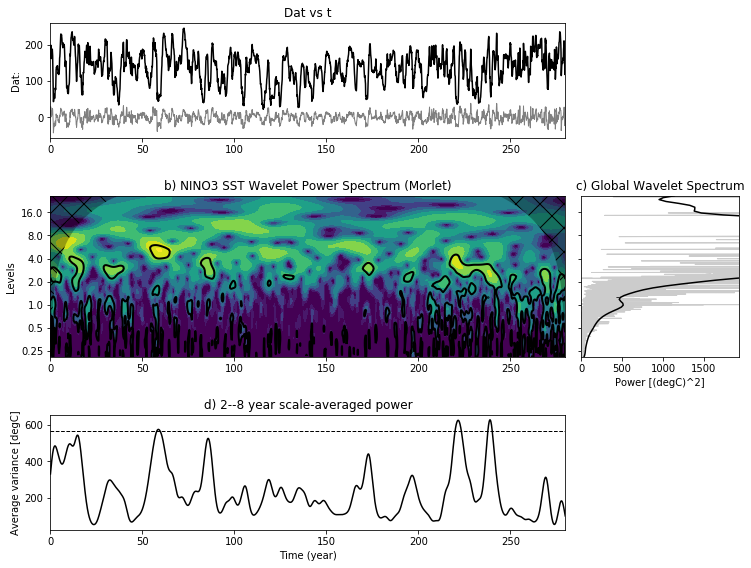

In [143]:
# Prepare the figure
pyplot.close('all')
pyplot.ioff()
figprops = dict(figsize=(11, 8), dpi=72)
fig = pyplot.figure(**figprops)
# First sub-plot, the original time series anomaly and inverse wavelet
# transform.
ax = pyplot.axes([0.1, 0.75, 0.65, 0.2])
ax.plot(t, iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
ax.plot(t, dat, 'k', linewidth=1.5)
ax.set_title('Dat vs t')
ax.set_ylabel('Dat:')
# Second sub-plot, the normalized wavelet power spectrum and significance
# level contour lines and cone of influece hatched area. Note that period
# scale is logarithmic.
bx = pyplot.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
bx.contourf(t, numpy.log2(period), numpy.log2(power), numpy.log2(levels),
extend='both', cmap=pyplot.cm.viridis)
extent = [t.min(), t.max(), 0, max(period)]
bx.contour(t, numpy.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
extent=extent)
bx.fill(numpy.concatenate([t, t[-1:] + dt, t[-1:] + dt,
t[:1] - dt, t[:1] - dt]),
numpy.concatenate([numpy.log2(coi), [1e-9], numpy.log2(period[-1:]),
numpy.log2(period[-1:]), [1e-9]]),
'k', alpha=0.3, hatch='x')
bx.set_title('b) {} Wavelet Power Spectrum ({})'.format(label, mother.name))
bx.set_ylabel('Levels ')
#
Yticks = 2 ** numpy.arange(numpy.ceil(numpy.log2(period.min())),
numpy.ceil(numpy.log2(period.max())))
bx.set_yticks(numpy.log2(Yticks))
bx.set_yticklabels(Yticks)

# Third sub-plot, the global wavelet and Fourier power spectra and theoretical
# noise spectra. Note that period scale is logarithmic.
cx = pyplot.axes([0.77, 0.37, 0.2, 0.28], sharey=bx)
cx.plot(glbl_signif, numpy.log2(period), 'k--')
cx.plot(var * fft_theor, numpy.log2(period), '--', color='#cccccc')
cx.plot(var * fft_power, numpy.log2(1./fftfreqs), '-', color='#cccccc',
linewidth=1.)
cx.plot(var * glbl_power, numpy.log2(period), 'k-', linewidth=1.5)
cx.set_title('c) Global Wavelet Spectrum')
cx.set_xlabel(r'Power [({})^2]'.format(units))
cx.set_xlim([0, glbl_power.max() + var])
cx.set_ylim(numpy.log2([period.min(), period.max()]))
cx.set_yticks(numpy.log2(Yticks))
cx.set_yticklabels(Yticks)
pyplot.setp(cx.get_yticklabels(), visible=False)
# Fourth sub-plot, the scale averaged wavelet spectrum.
dx = pyplot.axes([0.1, 0.07, 0.65, 0.2], sharex=ax)
dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
dx.plot(t, scale_avg, 'k-', linewidth=1.5)
dx.set_title('d) {}--{} year scale-averaged power'.format(2, 8))
dx.set_xlabel('Time (year)')
dx.set_ylabel(r'Average variance [{}]'.format(units))
ax.set_xlim([t.min(), t.max()])

pyplot.show()


In [ ]:
dat = img[1, :]
t0=0
dt=0.25

#our_data

In [129]:
#dat = img[2, :]

def return_area_ratio(dat):
    t0=0
    dt=0.25
    N = dat.size
    t = numpy.arange(0, N) * dt + t0
    p = numpy.polyfit(t - t0, dat, 1)
    dat_notrend = dat - numpy.polyval(p, t - t0)
    std = dat_notrend.std() # Standard deviation
    var = std ** 2 # Variance
    dat_norm = dat_notrend / std # Normalized dataset

    mother = wavelet.Morlet(6)
    s0 = 2 * dt # Starting scale, in this case 2 * 0.25 years = 6 months
    dj = 1 / 12 # Twelve sub-octaves per octaves
    J = 7 / dj # Seven powers of two with dj sub-octaves
    alpha, _, _ = wavelet.ar1(dat) # Lag-1 autocorrelation for red noise

    wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J,
    mother)
    iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std

    power = (numpy.abs(wave)) ** 2
    fft_power = numpy.abs(fft) ** 2
    period = 1 / freqs

    power /= scales[:, None]

    signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
    significance_level=0.95,
    wavelet=mother)
    sig95 = numpy.ones([1, N]) * signif[:, None]
    sig95 = power / sig95
    glbl_power = power.mean(axis=1)
    dof = N - scales # Correction for padding at edges
    glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
    significance_level=0.95, dof=dof,
    wavelet=mother)

    sel = find((period >= 2) & (period < 8))
    Cdelta = mother.cdelta
    scale_avg = (scales * numpy.ones((N, 1))).transpose()
    scale_avg = power / scale_avg # As in Torrence and Compo (1998) equation 24
    scale_avg = var * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
    scale_avg_signif, tmp = wavelet.significance(var, dt, scales, 2, alpha,
    significance_level=0.95,
    dof=[scales[sel[0]],
    scales[sel[-1]]],
    wavelet=mother)

    glbl_power = power.sum(axis=1)/float(N)

    a= var * glbl_power
    n = len(a)
    d = n//7
    areas = []
    total = simps(a, dx=1)
    for i in range(7):
        try:
            areas.append(simps(a[i*d:(i+1)*d], dx=1)/total)
        except:
            areas.append(simps(a[i*d:], dx=1)/total)

    return np.array(areas)

def row_and_column_features(img,for_row=200,for_col=280):
    d_row = img.shape[0]//for_row
    d_col = img.shape[1]//for_col
    data_r = np.apply_along_axis(return_area_ratio,1,img[np.arange(for_row)*d_row,:]).mean(axis=0)
    data_c = np.apply_along_axis(return_area_ratio,1,img[:,np.arange(for_col)*d_col]).mean(axis=0)
    return np.concatenate((data_r,data_c),axis=0)

dat = img[2, :]
row_and_column_features(img)

array([0.00661046, 0.01851191, 0.04663658, 0.14276981, 0.2928723 ,
       0.26445492, 0.14163053, 0.22252917, 0.29104111, 0.21473484,
       0.10366164, 0.05119385, 0.02458846, 0.01525358])

In [138]:
pd.DataFrame(np.stack(([1,2],[3,2])),columns=['a','b'])

,a,b
0,1,2
1,3,2


In [117]:
def f(x):
    print(x.shape)
data=np.apply_along_axis(return_area_ratio,1,img[np.arange(200)*10,:])



In [123]:
data.mean(axis=0)

array([0.00661046, 0.01851191, 0.04663658, 0.14276981, 0.2928723 ,
       0.26445492, 0.14163053])

In [103]:
img.shape

(2000, 2800)

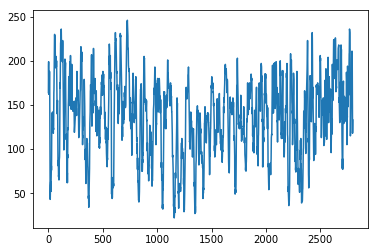

In [7]:
plt.plot(np.arange(dat.size), dat)

In [8]:
N = dat.size
t = numpy.arange(0, N) * dt + t0

In [9]:
p = numpy.polyfit(t - t0, dat, 1)
dat_notrend = dat - numpy.polyval(p, t - t0)
std = dat_notrend.std() # Standard deviation
var = std ** 2 # Variance
dat_norm = dat_notrend / std # Normalized dataset

In [10]:
mother = wavelet.Morlet(6)
s0 = 2 * dt # Starting scale, in this case 2 * 0.25 years = 6 months
dj = 1 / 12 # Twelve sub-octaves per octaves
J = 7 / dj # Seven powers of two with dj sub-octaves
alpha, _, _ = wavelet.ar1(dat) # Lag-1 autocorrelation for red noise

In [11]:
alpha

0.9751300571526338

In [12]:
wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J,
mother)
iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std

In [13]:
iwave[:]

array([  3.75620403+0.j,  18.39479859+0.j,  17.21184209+0.j, ...,
       -14.79850941+0.j, -11.20385777+0.j,  -3.18666028+0.j])

In [14]:
power = (numpy.abs(wave)) ** 2
fft_power = numpy.abs(fft) ** 2
period = 1 / freqs

In [15]:
power /= scales[:, None]

In [17]:
signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
significance_level=0.95,
wavelet=mother)
sig95 = numpy.ones([1, N]) * signif[:, None]
sig95 = power / sig95
glbl_power = power.mean(axis=1)
dof = N - scales # Correction for padding at edges
glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
significance_level=0.95, dof=dof,
wavelet=mother)

In [21]:
sel = find((period >= 2) & (period < 8))
Cdelta = mother.cdelta
scale_avg = (scales * numpy.ones((N, 1))).transpose()
scale_avg = power / scale_avg # As in Torrence and Compo (1998) equation 24
scale_avg = var * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
scale_avg_signif, tmp = wavelet.significance(var, dt, scales, 2, alpha,
significance_level=0.95,
dof=[scales[sel[0]],
scales[sel[-1]]],
wavelet=mother)

E:\stdy\anaconda\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


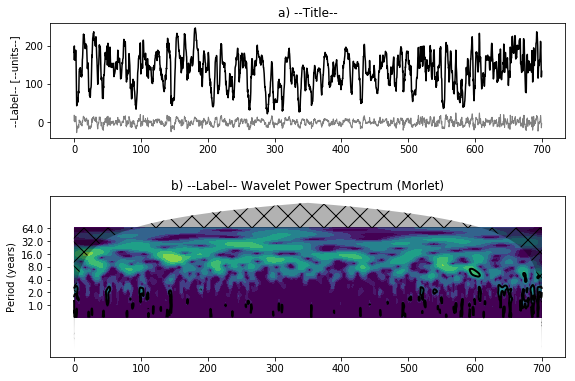

In [25]:
# Prepare the figure
title = '--Title--'
label = '--Label--'
units= '--units--'

pyplot.close('all')
pyplot.ioff()
figprops = dict(figsize=(11, 8), dpi=72)
fig = pyplot.figure(**figprops)
# First sub-plot, the original time series anomaly and inverse wavelet
# transform.
ax = pyplot.axes([0.1, 0.75, 0.65, 0.2])
ax.plot(t, iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
ax.plot(t, dat, 'k', linewidth=1.5)
ax.set_title('a) {}'.format(title))
ax.set_ylabel(r'{} [{}]'.format(label, units))
# Second sub-plot, the normalized wavelet power spectrum and significance
# level contour lines and cone of influece hatched area. Note that period
# scale is logarithmic.
bx = pyplot.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
bx.contourf(t, numpy.log2(period), numpy.log2(power), numpy.log2(levels),
extend='both', cmap=pyplot.cm.viridis)
extent = [t.min(), t.max(), 0, max(period)]
bx.contour(t, numpy.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
extent=extent)
bx.fill(numpy.concatenate([t, t[-1:] + dt, t[-1:] + dt,
t[:1] - dt, t[:1] - dt]),
numpy.concatenate([numpy.log2(coi), [1e-9], numpy.log2(period[-1:]),
numpy.log2(period[-1:]), [1e-9]]),
'k', alpha=0.3, hatch='x')
bx.set_title('b) {} Wavelet Power Spectrum ({})'.format(label, mother.name))
bx.set_ylabel('Period (years)')
#
Yticks = 2 ** numpy.arange(numpy.ceil(numpy.log2(period.min())),
numpy.ceil(numpy.log2(period.max())))
bx.set_yticks(numpy.log2(Yticks))
bx.set_yticklabels(Yticks)


In [38]:
(power.sum(axis=1)/float(N)-glbl_power)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

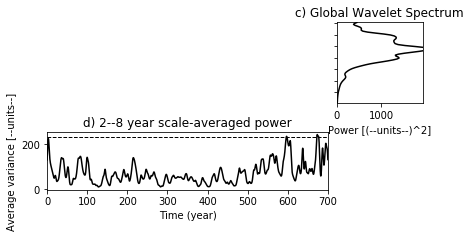

In [31]:
# Third sub-plot, the global wavelet and Fourier power spectra and theoretical
# noise spectra. Note that period scale is logarithmic.
cx = pyplot.axes([0.77, 0.37, 0.2, 0.28], sharey=bx)
#cx.plot(glbl_signif, numpy.log2(period), 'k--')
#cx.plot(var * fft_theor, numpy.log2(period), '--', color='#cccccc')
#cx.plot(var * fft_power, numpy.log2(1./fftfreqs), '-', color='#cccccc',
#linewidth=1.)
cx.plot(var * glbl_power, numpy.log2(period), 'k-', linewidth=1.5)
cx.set_title('c) Global Wavelet Spectrum')
cx.set_xlabel(r'Power [({})^2]'.format(units))
cx.set_xlim([0, glbl_power.max() + var])
cx.set_ylim(numpy.log2([period.min(), period.max()]))
cx.set_yticks(numpy.log2(Yticks))
cx.set_yticklabels(Yticks)
pyplot.setp(cx.get_yticklabels(), visible=False)
# Fourth sub-plot, the scale averaged wavelet spectrum.
dx = pyplot.axes([0.1, 0.07, 0.65, 0.2], sharex=ax)
dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
dx.plot(t, scale_avg, 'k-', linewidth=1.5)
dx.set_title('d) {}--{} year scale-averaged power'.format(2, 8))
dx.set_xlabel('Time (year)')
dx.set_ylabel(r'Average variance [{}]'.format(units))
ax.set_xlim([t.min(), t.max()])

pyplot.show()


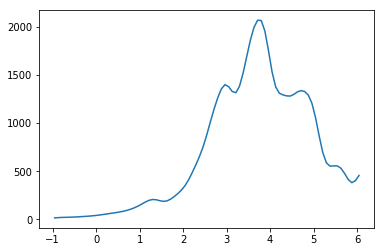

In [41]:
plt.plot( numpy.log2(period),var * glbl_power)

In [86]:
numpy.log2(period).max()/5

1.2093802423335425

In [42]:
from scipy.integrate import simps

In [80]:
a= var * glbl_power
n = len(a)

In [90]:
d = n//7
total = simps(a, dx=1)
for i in range(7):
    try:
        print(simps(a[i*d:(i+1)*d], dx=1)/total)
    except:
        print(simps(a[i*d:], dx=1)/total)

0.004790594830857201
0.014999392786363537
0.03994216185805334
0.1637295261296684
0.32604319082204836
0.25171631505429504
0.1098981091762679


In [76]:
simps(a, dx=0.1)

5754.554994496001

In [71]:
simps(a, dx=0.003)

172.63664983488002